# Find nights with Auxtel Holo exposure in OGA butler

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-02-19
- last update : 2024-02-19
- affiliation : IJCLab/IN2P3/CNRS
- Work with w_2024_07

The goal is to check the number of data available, their date.

## Imports

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [4]:
import matplotlib.ticker
%matplotlib inline

In [5]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys

In [6]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [7]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208/20231220T142452Z
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221/20231221T125249Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201/20240201T144534Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5/20240215T190316Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150/2024

## Config

In [8]:
file_listexposures_in_csv = "holo_list_exposures_oga.csv"

## Read file

In [11]:
df_exp = pd.read_csv(file_listexposures_in_csv)

In [12]:
df_exp

,Unnamed: 0,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,657,2022091200104,AT_O_20220912_000104,20220912,104,2022-09-13 01:20:16.390009,2022-09-13 01:20:46.618,science,HD167060,empty~ronchi170lpmm,35.761102,30.0,274.485264,-61.742148,130.613923,200.833163,35.761102,unknown,2.459836e+06,59835.055745
1,650,2022091200105,AT_O_20220912_000105,20220912,105,2022-09-13 01:20:59.277003,2022-09-13 01:21:29.513,science,HD167060,empty~ronchi170lpmm,35.816568,30.0,274.485275,-61.742168,130.613889,200.943213,35.816568,unknown,2.459836e+06,59835.056242
2,652,2022091200106,AT_O_20220912_000106,20220912,106,2022-09-13 01:21:48.291985,2022-09-13 01:22:18.520,science,HD167060,empty~holo4_003,35.884569,30.0,274.485183,-61.742210,130.613866,201.067976,35.884569,unknown,2.459836e+06,59835.056809
3,654,2022091200107,AT_O_20220912_000107,20220912,107,2022-09-13 01:22:31.094006,2022-09-13 01:23:01.329,science,HD167060,empty~holo4_003,35.940561,30.0,274.485217,-61.742150,130.613861,201.176876,35.940561,unknown,2.459836e+06,59835.057304
4,660,2022091200111,AT_O_20220912_000111,20220912,111,2022-09-13 01:24:55.866989,2022-09-13 01:25:26.113,science,HD2811,empty~ronchi170lpmm,52.803456,30.0,7.828469,-43.566523,351.230009,123.786942,52.803456,unknown,2.459836e+06,59835.058980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27117,79317,2024021500343,AT_O_20240215_000343,20240215,343,2024-02-16 07:41:16.508018,2024-02-16 07:41:46.749,science,523811 (2008 TQ2).V=18.719,SDSSr_65mm~empty,45.057398,30.0,146.404683,-10.151018,359.994226,286.877713,45.057398,BLOCK-231,2.460357e+06,60356.320330
27118,79318,2024021500344,AT_O_20240215_000344,20240215,344,2024-02-16 07:41:49.242985,2024-02-16 07:42:19.483,science,523811 (2008 TQ2).V=18.719,SDSSr_65mm~empty,45.171762,30.0,146.404335,-10.150810,359.994650,286.773922,45.171762,BLOCK-231,2.460357e+06,60356.320709
27119,79319,2024021500345,AT_O_20240215_000345,20240215,345,2024-02-16 07:43:05.724002,2024-02-16 07:44:05.979,science,523811 (2008 TQ2).V=18.719,SDSSr_65mm~empty,45.434433,60.0,146.404390,-10.150770,359.994726,286.536309,45.434433,BLOCK-231,2.460357e+06,60356.321594
27120,79320,2024021500346,AT_O_20240215_000346,20240215,346,2024-02-16 07:44:08.474014,2024-02-16 07:45:08.719,science,523811 (2008 TQ2).V=18.719,SDSSr_65mm~empty,45.652390,60.0,146.404408,-10.150827,359.994456,286.340559,45.652390,BLOCK-231,2.460357e+06,60356.322320


In [13]:
df_exp["year"] = df_exp["day_obs"].apply(lambda x : x//10_000)
df_exp["yearmonth"] = df_exp["day_obs"].apply(lambda x : x//100)
df_exp["time"] = pd.to_datetime(df_exp['time_start'])

In [14]:
df_exp["day_obs"].unique()

array([20220912, 20220913, 20220914, 20220927, 20220928, 20220929,
       20221011, 20221012, 20221013, 20221025, 20221026, 20221027,
       20221108, 20221109, 20221110, 20221122, 20221123, 20221124,
       20221207, 20221208, 20221209, 20221210, 20221212, 20230117,
       20230118, 20230119, 20230131, 20230201, 20230202, 20230214,
       20230215, 20230216, 20230228, 20230301, 20230302, 20230314,
       20230315, 20230316, 20230509, 20230510, 20230511, 20230523,
       20230524, 20230525, 20230704, 20230705, 20230706, 20230718,
       20230720, 20230801, 20230802, 20230803, 20230815, 20230816,
       20230817, 20230829, 20230912, 20230913, 20230914, 20230926,
       20230927, 20230928, 20231010, 20231011, 20231107, 20231108,
       20231113, 20231114, 20231115, 20231116, 20231120, 20231121,
       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
       20231219, 20231220, 20231221, 20231222, 20240129, 20240

### Time series

In [16]:
df_exp_visit = df_exp.groupby(['day_obs']).count()["id"]
df_exp_visit.name = "countVisitperBandperNight" 
df_exp_visit

day_obs
20220912    319
20220913    614
20220914    423
20220927    380
20220928    644
           ... 
20240208     63
20240212    157
20240213    136
20240214     49
20240215    140
Name: countVisitperBandperNight, Length: 99, dtype: int64

## Selection of the date

In [23]:
cut1 = df_exp["filter"] == "empty~holo4_003"
cut2 = df_exp["year"] == 2024
all_cuts = cut1 & cut2

In [24]:
df_sel = df_exp[all_cuts ]

In [25]:
df_sel

,Unnamed: 0,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter,...,dec,skyangle,azimuth,zenith,science_program,jd,mjd,year,yearmonth,time
26073,75991,2024012900293,AT_O_20240129_000293,20240129,293,2024-01-30 01:11:03.982987,2024-01-30 01:12:04.229,science,HD38666,empty~holo4_003,...,-32.310198,188.778375,105.099640,9.693174,spec-survey,2.460340e+06,60339.049352,2024,202401,2024-01-30 01:11:03.982987
26074,75992,2024012900294,AT_O_20240129_000294,20240129,294,2024-01-30 01:12:17.013008,2024-01-30 01:13:17.253,science,HD38666,empty~holo4_003,...,-32.310193,188.778288,105.356590,9.438961,spec-survey,2.460340e+06,60339.050197,2024,202401,2024-01-30 01:12:17.013008
26078,76015,2024012900316,AT_O_20240129_000316,20240129,316,2024-01-30 01:46:33.161984,2024-01-30 01:47:33.406,science,HD73495,empty~holo4_003,...,-26.250333,343.363520,95.846388,39.720648,spec-survey,2.460340e+06,60339.073995,2024,202401,2024-01-30 01:46:33.161984
26079,76016,2024012900317,AT_O_20240129_000317,20240129,317,2024-01-30 01:47:46.091019,2024-01-30 01:48:46.337,science,HD73495,empty~holo4_003,...,-26.250318,343.363469,95.724849,39.458608,spec-survey,2.460340e+06,60339.074839,2024,202401,2024-01-30 01:47:46.091019
26083,76022,2024012900323,AT_O_20240129_000323,20240129,323,2024-01-30 01:56:30.220986,2024-01-30 01:57:30.451,science,HD185975,empty~holo4_003,...,-87.476776,230.050666,182.000283,61.666446,spec-survey,2.460340e+06,60339.080905,2024,202401,2024-01-30 01:56:30.220986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27062,79260,2024021500286,AT_O_20240215_000286,20240215,286,2024-02-16 06:33:31.823004,2024-02-16 06:34:02.061,science,HD73495,empty~holo4_003,...,-26.262442,196.338934,264.813779,38.258523,spec-survey,2.460357e+06,60356.273285,2024,202402,2024-02-16 06:33:31.823004
27063,79261,2024021500287,AT_O_20240215_000287,20240215,287,2024-02-16 06:34:14.838985,2024-02-16 06:34:45.068,science,HD73495,empty~holo4_003,...,-26.262438,196.338858,264.741180,38.412971,spec-survey,2.460357e+06,60356.273783,2024,202402,2024-02-16 06:34:14.838985
27067,79267,2024021500293,AT_O_20240215_000293,20240215,293,2024-02-16 06:40:49.244007,2024-02-16 06:41:49.482,science,HD185975,empty~holo4_003,...,-87.465379,316.183148,177.880300,61.586790,spec-survey,2.460357e+06,60356.278348,2024,202402,2024-02-16 06:40:49.244007
27068,79268,2024021500294,AT_O_20240215_000294,20240215,294,2024-02-16 06:42:02.329992,2024-02-16 06:43:02.569,science,HD185975,empty~holo4_003,...,-87.465352,316.183589,177.868973,61.577023,spec-survey,2.460357e+06,60356.279194,2024,202402,2024-02-16 06:42:02.329992


## Selection with hologram

In [26]:
df_sel_visit = df_sel.groupby(['day_obs']).count()["id"]
df_sel_visit.name = "countVisitperBandperNight" 
df_sel_visit

day_obs
20240129    10
20240130    10
20240131     2
20240205     8
20240206    46
20240207    12
20240212    20
20240213    38
20240214    20
20240215    15
Name: countVisitperBandperNight, dtype: int64

Text(0.5, 1.0, 'Auxtel Spectro Year 2024 nspec = 181 ndays = 10 (/repo/embargo)')

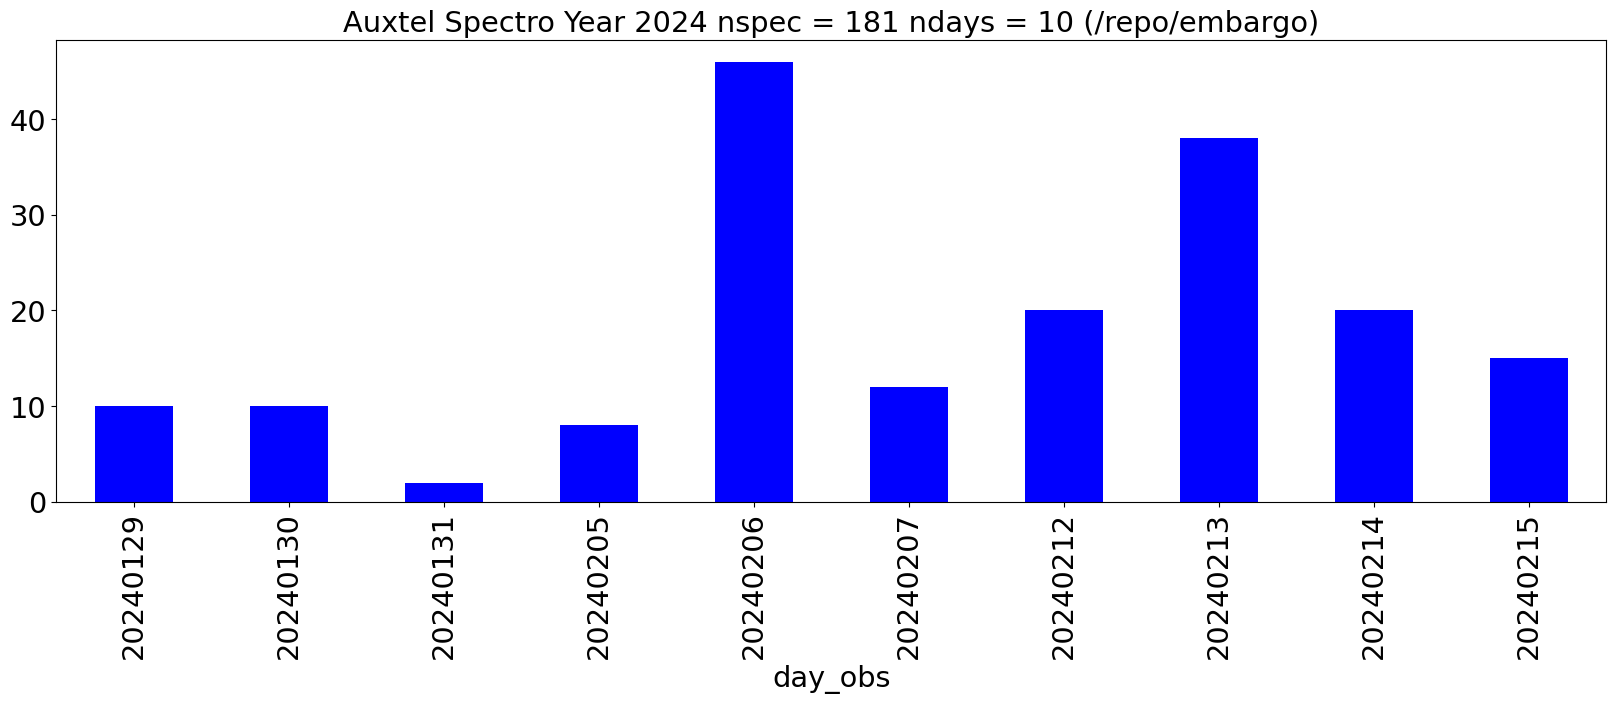

In [27]:
nspec = df_sel_visit.sum()
ndays = df_sel_visit.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} ndays = {ndays} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_sel_visit.plot(x='day_obs',kind="bar",facecolor="b",ax=ax)
ax.set_title(suptitle)

Text(0.5, 0, 'year,month,day')

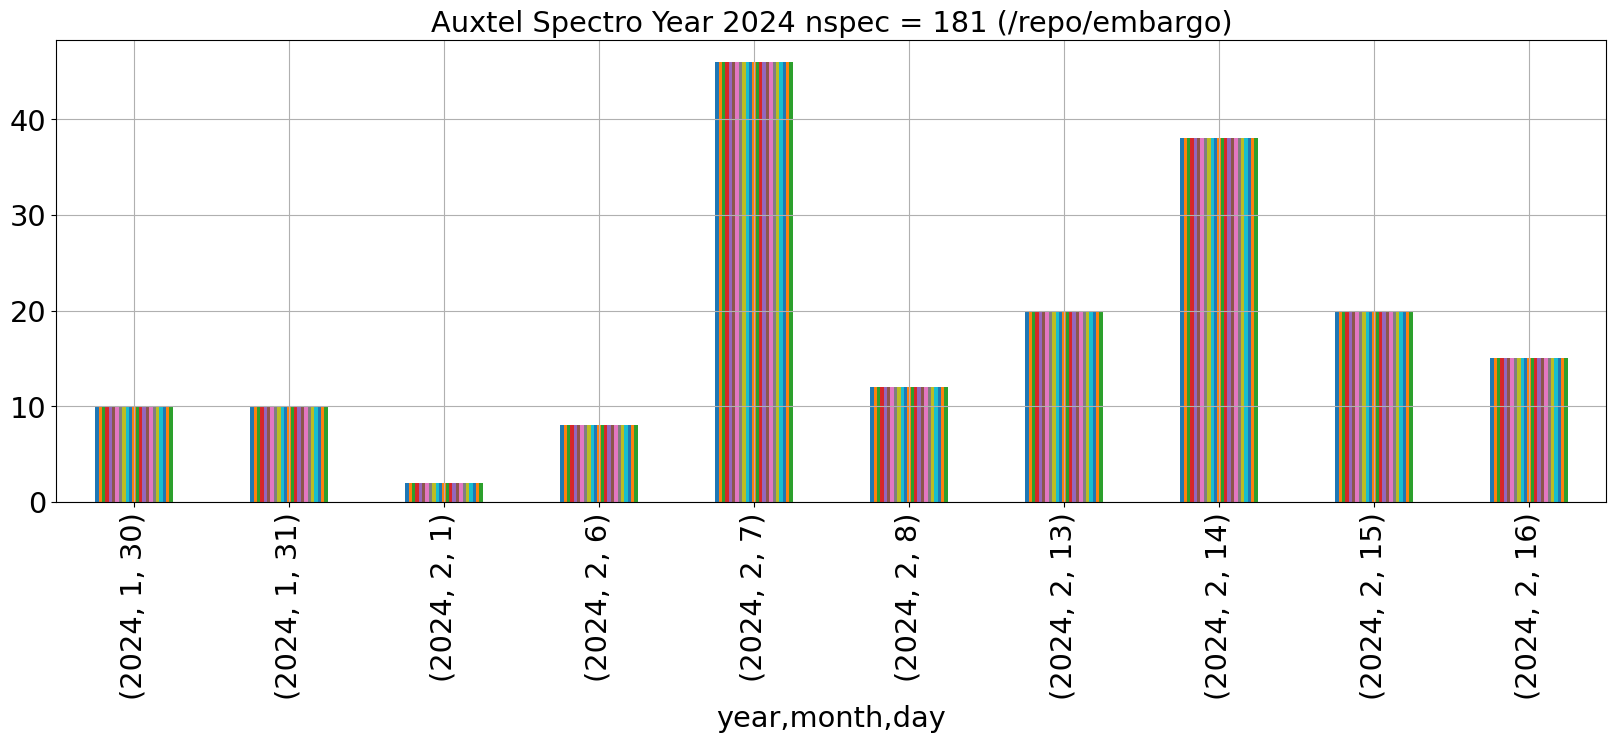

In [29]:
nspec = df_sel.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_sel.groupby([df_sel["time"].dt.year, df_sel["time"].dt.month,df_sel["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

## Save the series

In [31]:
df_sel_visit.to_csv("exposuresholo_series_repo_embargo_29jan-15feb2024.csv")

### Year 2024

In [32]:
df_sel["day_obs"].unique()

array([20240129, 20240130, 20240131, 20240205, 20240206, 20240207,
       20240212, 20240213, 20240214, 20240215])

In [33]:
df_sel["filter"].unique()

array(['empty~holo4_003'], dtype=object)

In [34]:
df_sel.target.unique()

array(['HD38666', 'HD73495', 'HD185975', 'HD2811',
       '483508 (2003 CR1).V=18.114'], dtype=object)

In [35]:
df_sel.science_program.unique()

array(['spec-survey', 'BLOCK-228'], dtype=object)

In [37]:
#df_sel.obs_reason.unique()

## Plot Year 2024

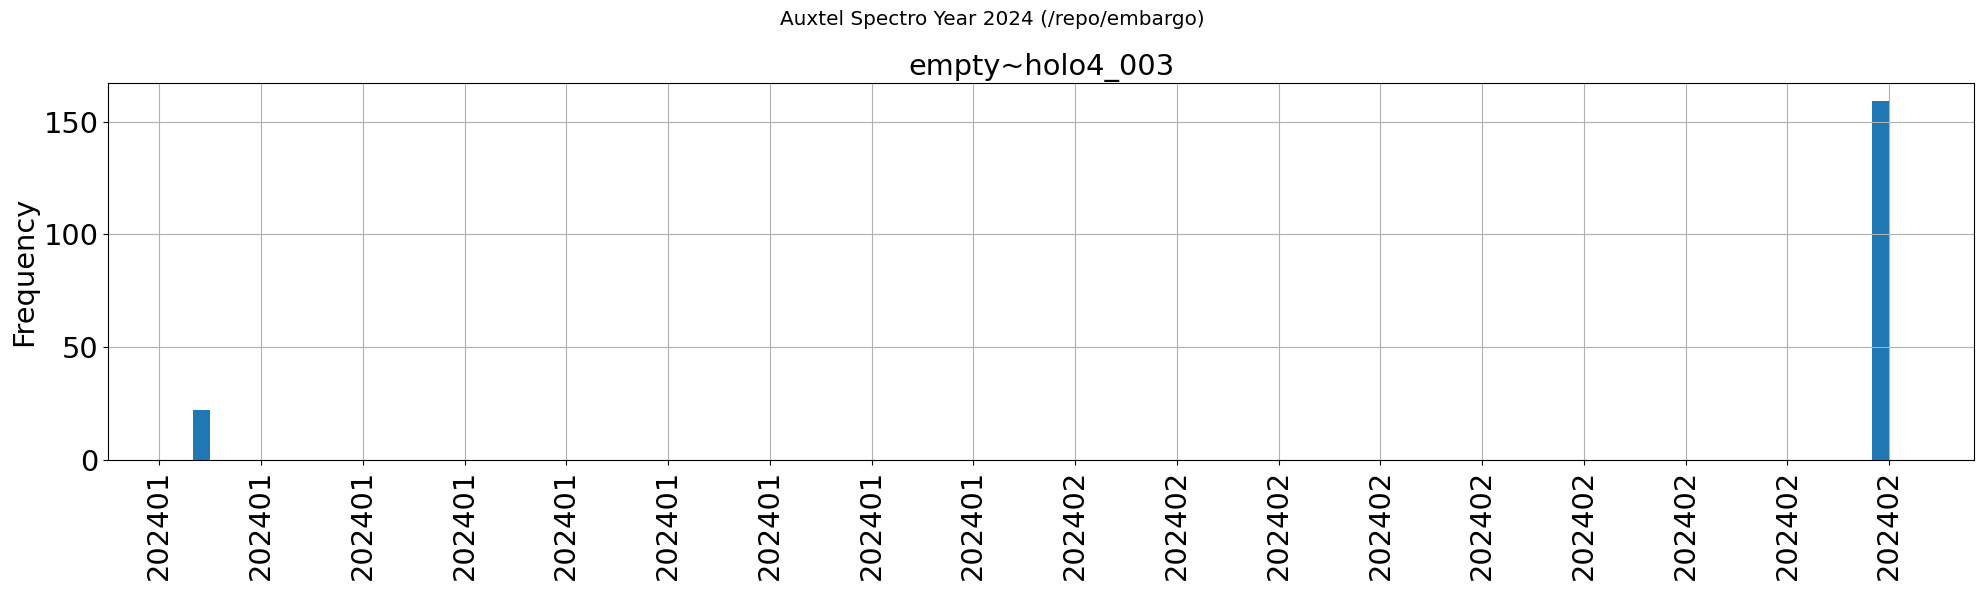

In [38]:
suptitle = "Auxtel Spectro Year 2024 (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_sel.plot.hist(column=["yearmonth"] ,by="filter",bins=100,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(1)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

In [39]:
df_sel.id.count()

181

Text(0.5, 0, 'year,month,day')

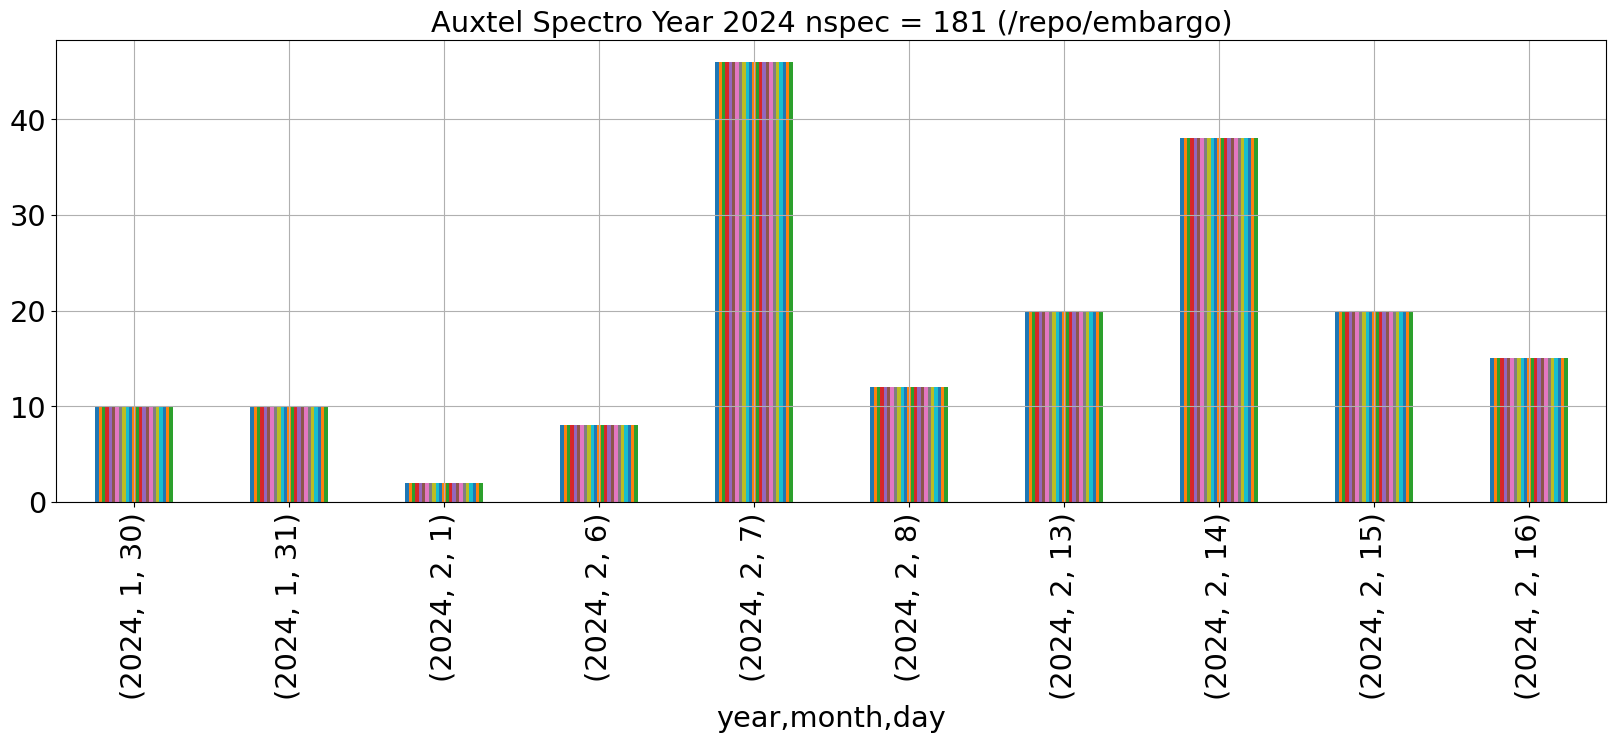

In [40]:
nspec = df_sel.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_sel.groupby([df_sel["time"].dt.year, df_sel["time"].dt.month,df_sel["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

### Plot Year 2024

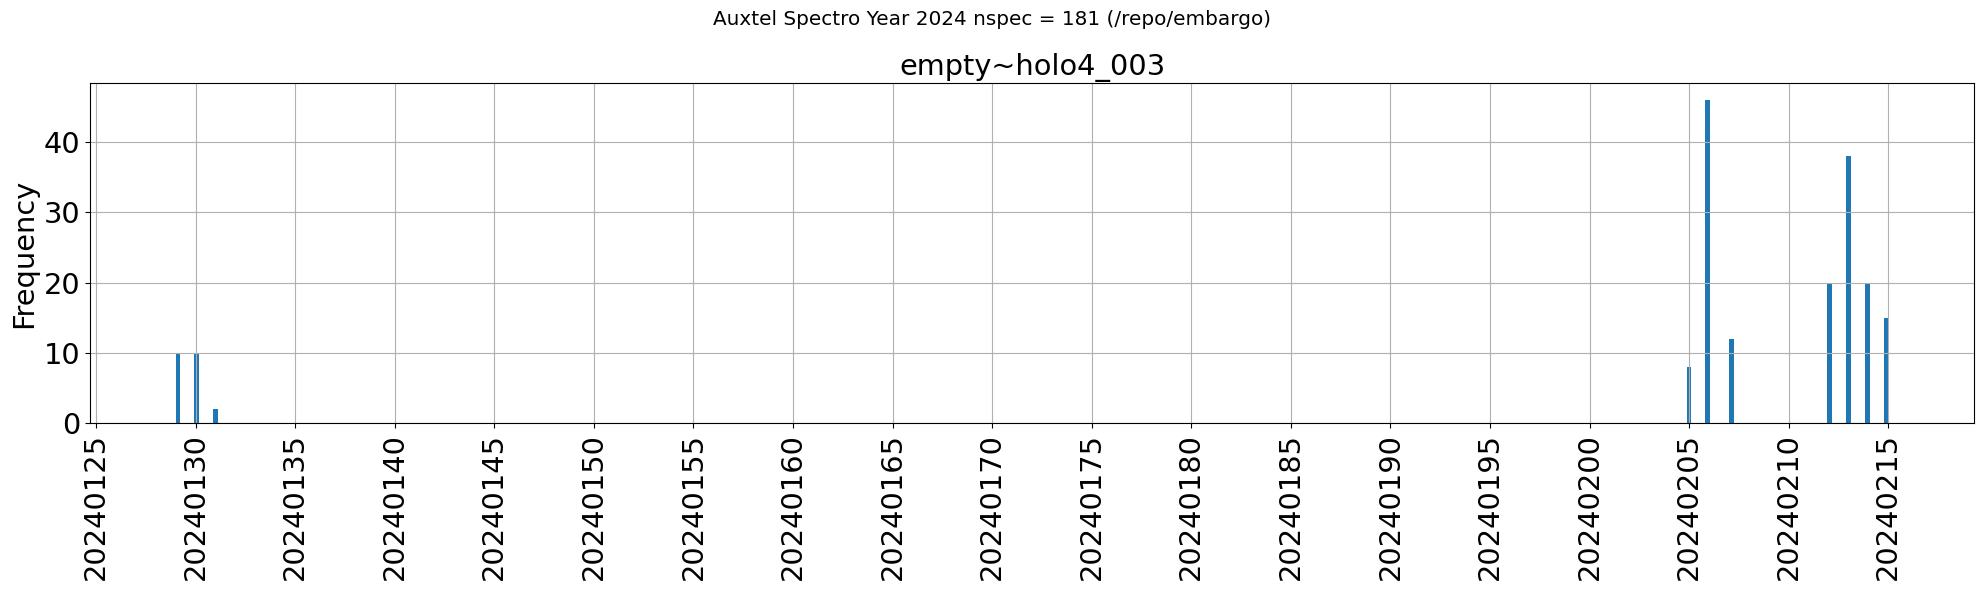

In [41]:
nspec = df_sel.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"

fig,ax = plt.subplots(1,1,figsize=(20,6))
df_sel.plot.hist(column=["day_obs"] ,by="filter",bins=365,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(1)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

Text(0.5, 0, 'year,month,day')

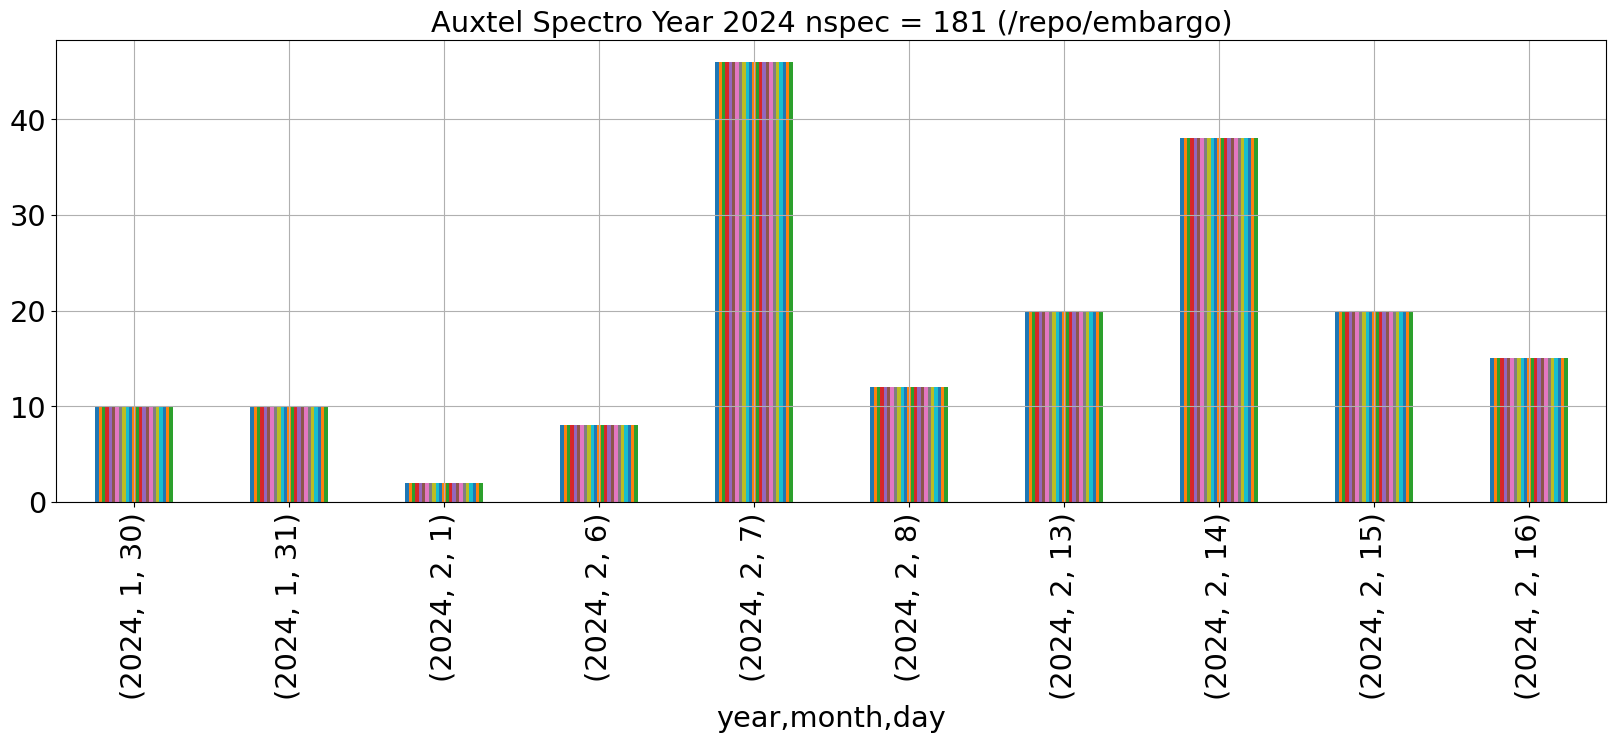

In [42]:
nspec = df_sel.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"

fig,ax = plt.subplots(1,1,figsize=(20,6))
df_sel.groupby([df_sel["time"].dt.year, df_sel["time"].dt.month,df_sel["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

# Visits

In [43]:
df_sel_visit.cumsum()

day_obs
20240129     10
20240130     20
20240131     22
20240205     30
20240206     76
20240207     88
20240212    108
20240213    146
20240214    166
20240215    181
Name: countVisitperBandperNight, dtype: int64

In [44]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [45]:
dt = [ convertNumToDatestr(num) for num in df_sel_visit.index ]

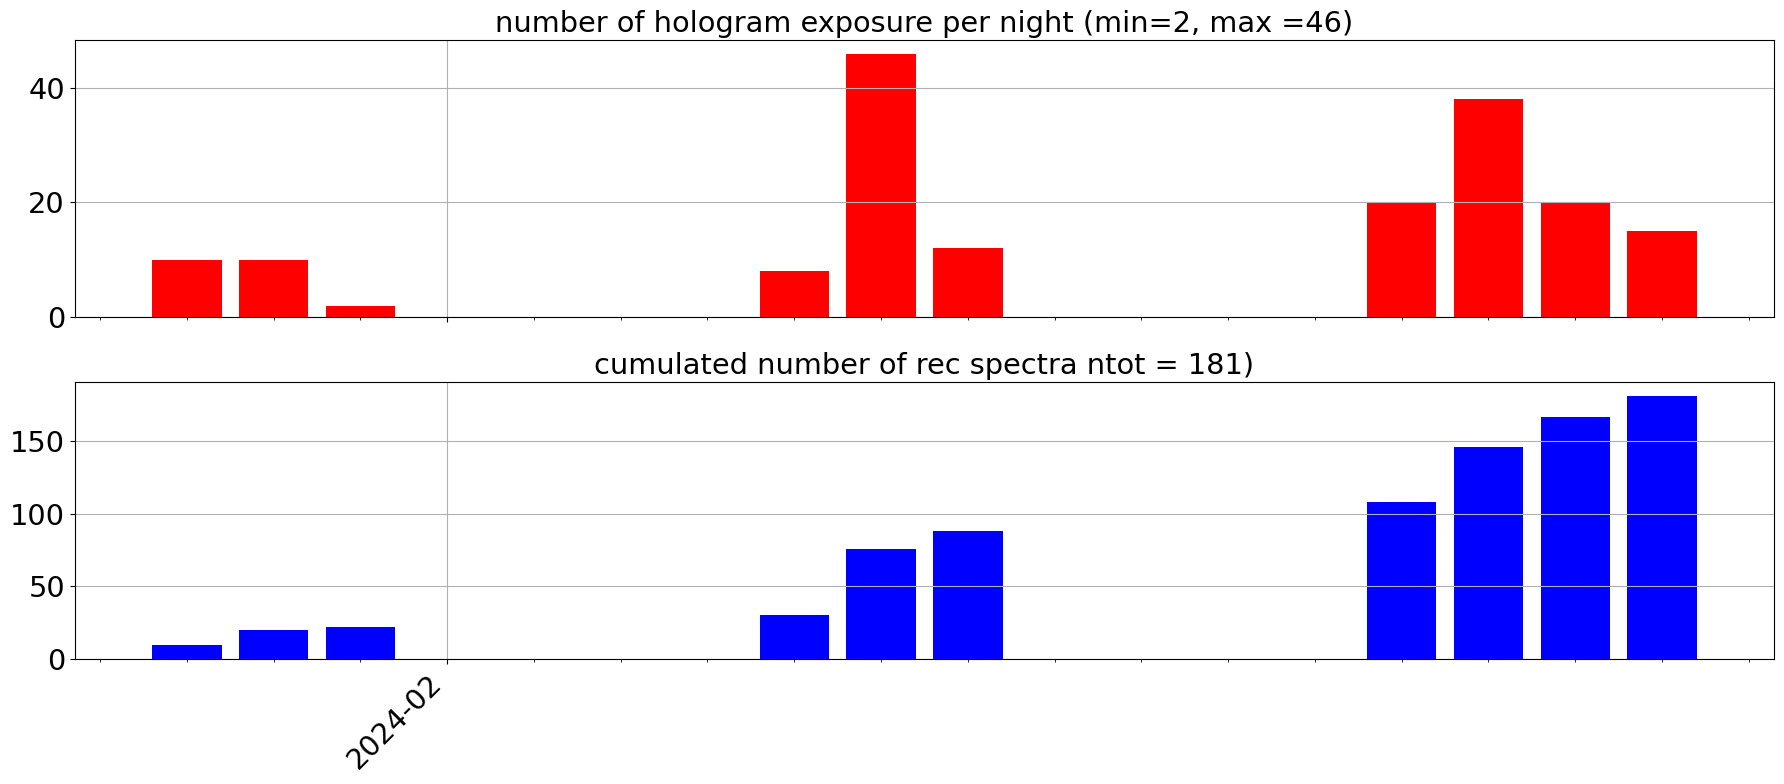

In [47]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(18, 8),sharex=True)


# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt,df_sel_visit.values,lw=5,facecolor='r')
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()

minnspec= df_sel_visit.min()
maxnspec= df_sel_visit.max()
totnspec= df_sel_visit.sum()
title1 = f"number of hologram exposure per night (min={minnspec}, max ={maxnspec})"
ax1.set_title(title1)

#fig.autofmt_xdate() # rotation
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

ax2.bar(dt,df_sel_visit.cumsum().values,lw=5,facecolor='b')
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()

#fig.autofmt_xdate() # rotation
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
title2 = f"cumulated number of rec spectra ntot = {totnspec})"
ax2.set_title(title2)

plt.tight_layout()